In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_7_image_16_4_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_12_image_4_2_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_7_image_9_3_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_17_image_20_3_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_20_image_5_1_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_21_image_17_2_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam/planet/planet_page_11_image_2_2_SwinIR_large.png
/kaggle/input/spacenet-an-optimally-dist

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image, ImageFile
import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Device
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


CUDA available: True
Using device: cuda


In [7]:
def safe_pil_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except:
        return Image.new("RGB", (96, 96), (0, 0, 0))


In [8]:
DATASET_PATH = "/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam"

IMG_SIZE = 96          
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

full_dataset = datasets.ImageFolder(
    root=DATASET_PATH,
    transform=transform,
    loader=safe_pil_loader
)

print("Classes:", full_dataset.classes)
NUM_CLASSES = len(full_dataset.classes)


train_size = int(0.7 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
rest = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, _ = random_split(
    full_dataset, [train_size, val_size, rest]
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


Classes: ['asteroid', 'black hole', 'comet', 'constellation', 'galaxy', 'nebula', 'planet', 'star']


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 12 * 12, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [10]:
model = SimpleCNN(NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model device:", next(model.parameters()).device)


Model device: cuda:0


In [11]:
EPOCHS = 3   

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss:.4f} | Val Acc: {acc:.2f}%")


Epoch 1/3 | Loss: 1.4062 | Val Acc: 55.30%
Epoch 2/3 | Loss: 1.0397 | Val Acc: 58.42%
Epoch 3/3 | Loss: 0.8305 | Val Acc: 62.48%


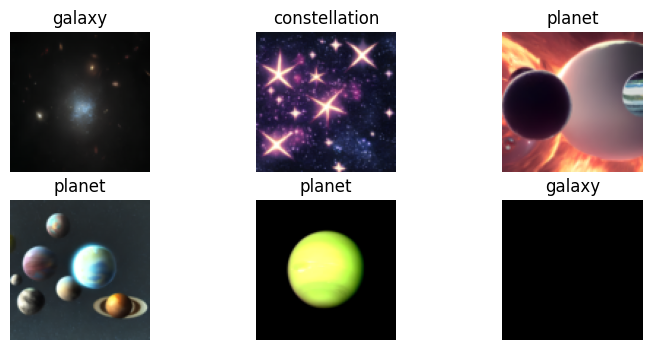

In [12]:
images, labels = next(iter(val_loader))
images = images.to(device)

outputs = model(images)
preds = outputs.argmax(dim=1)

plt.figure(figsize=(9, 4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    img = images[i].cpu().permute(1, 2, 0)
    plt.imshow((img + 1) / 2)
    plt.title(full_dataset.classes[preds[i]])
    plt.axis("off")
plt.show()
